In [1]:
import sys
sys.path.append("../../matter_emu_dgmgp-MF-Box-yanhui/")

import os
import numpy as np
from matter_multi_fidelity_emu.gpemulator_singlebin import SingleBindGMGP 
from matter_multi_fidelity_emu.data_loader import PowerSpecs
from matter_multi_fidelity_emu.data_loader_dgmgp import interpolate

import matplotlib.pyplot as plt
import contextlib
import io
import datetime

# set a random number seed to reproducibility
np.random.seed(0)

In [2]:
current_time = datetime.datetime.now().time()
print("Current time:", current_time)

Current time: 14:45:39.755158


In [3]:
from error_function.dgmgp_error import generate_data

def input_norm(cosmo_params: np.ndarray, bounds):
    cosmo_params_norm = np.zeros_like(cosmo_params)
    for i in range(len(cosmo_params)):
        for j in range(len(bounds)):
            cosmo_params_norm[i][j] = (cosmo_params[i][j] - bounds[j][0]) / (bounds[j][1] - bounds[j][0])
    return cosmo_params_norm

def matter_power_emu(cosmo_params, z: float = 0., n_optimization_restarts: int = 10, parallel: bool = False):
    """
    This function returns the matter power spectrum at redshift z for a given set of cosmological parameters.

    The cosmological parameters are in the same order as the training data.
    """

    # Load the training data
    folder_1 = "../data/matter_power_270_Box100_Part75_18_Box100_Part300_z0"
    folder_2 = "../data/matter_power_270_Box25_Part75_18_Box100_Part300_z0"
    data_1, data_2 = generate_data(folder_1=folder_1, folder_2=folder_2)  # L1HF and L2HF data

    bounds = np.loadtxt("../data/matter_power_270_Box100_Part75_18_Box100_Part300_z0/input_limits.txt")
    cosmo_params_norm = input_norm(cosmo_params, bounds)
    print("cosmo_params_norm:", cosmo_params_norm)

    k = 10**data_1.kf  # k is the same for all data sets

    with contextlib.redirect_stdout(io.StringIO()):  # Redirect stdout to a null stream
        dgmgp = SingleBindGMGP(
            X_train=[data_1.X_train_norm[0], data_2.X_train_norm[0], data_1.X_train_norm[1]],
            Y_train=[data_1.Y_train_norm[0], data_2.Y_train_norm[0], data_1.Y_train_norm[1]],
            n_fidelities=2,
            n_samples=400,
            optimization_restarts=n_optimization_restarts,
            ARD_last_fidelity=False,
            parallel=parallel,
            )

        mean, var = dgmgp.predict(cosmo_params_norm)

        # use mode (maximumlikelihood) as the prediction, restore the spectrum from log10(P(k)) which distributes normally
        mode_P = 10**mean * np.exp(-var * (np.log(10)) ** 2)
        var_P = (
            10 ** (2 * mean)
            * np.exp(var * (np.log(10)) ** 2)
            * (np.exp(var * (np.log(10)) ** 2) - 1)
        )

    return k, mode_P, var_P

In [4]:
# input
# Omega_m Omega_b hubble scalar_amp ns w0 wa mnu Neff alphas MWDM_inverse
cosmo_params = np.array([0.264, 0.047, 0.73, 1.8e-09, 0.99, -1.11, 0.27999999999999997, 0.0825, 3.55, -0.01685, 0.0])
z = 0.0 # redshift

n_optimization_restarts = 15

In [5]:
# training and prediction
cosmo_params = cosmo_params.reshape(1, 11)

k, Pk, var_Pk = matter_power_emu(cosmo_params, z, n_optimization_restarts=n_optimization_restarts, parallel=True)



cosmo_params_norm: [[0.05714286 0.7        0.75       0.25       0.91666667 0.31666667
  0.81666667 0.18333333 0.96428571 0.19878049 0.        ]]


reconstraining parameters GP_regression.Gaussian_noise.variance
 /rhome/yyang440/bigdata/anaconda3/envs/gpy-env/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
 /rhome/yyang440/bigdata/anaconda3/envs/gpy-env/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /rhome/yyang440/bigdata/anaconda3/envs/gpy-env/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /rhome/yyang440/bigdata/anaconda3/envs/gpy-env/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /rhome/yyang440/bigdata/anaconda3/envs/gpy-env/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /rhome/yyang440/bigdata/anaconda3/envs/gpy-env/lib/pytho

In [6]:
from matter_multi_fidelity_emu.rebin_powerspectrum import modecount_rebin

# load true data
k_true, Pk_true, modes = np.loadtxt("/rhome/yyang440/bigdata/tentative_sims/test_11p_Box100_Part300_CDM/output/powerspectrum-1.0000.txt", unpack=True, usecols=(0, 1, 2))

# rebin and interpolate the true data to the same k values as the emulator
(k_true, Pk_true, modes) = modecount_rebin(k_true, Pk_true, modes)


In [7]:
from scipy.interpolate import interp1d
interpolation_function = interp1d(k_true, Pk_true, kind='linear')

Pk_true_interp = interpolation_function(k)

In [8]:
# relative error
rel_err = np.mean(np.abs(Pk - Pk_true_interp) / Pk_true_interp)

In [9]:
current_time = datetime.datetime.now().time()
print("Current time:", current_time)

Current time: 18:49:40.165394


In [10]:
k

array([ 0.251327  ,  0.26762924,  0.28498892,  0.30347462,  0.3231594 ,
        0.34412102,  0.36644232,  0.39021147,  0.4155224 ,  0.44247512,
        0.47117611,  0.50173879,  0.5342839 ,  0.56894004,  0.60584414,
        0.64514201,  0.68698893,  0.73155023,  0.77900198,  0.82953167,
        0.88333896,  0.94063644,  1.00165049,  1.06662221,  1.13580829,
        1.2094821 ,  1.28793474,  1.37147618,  1.46043651,  1.55516722,
        1.6560426 ,  1.76346123,  1.87784754,  1.99965347,  2.1293603 ,
        2.26748052,  2.41455986,  2.57117945,  2.73795812,  2.91555482,
        3.10467128,  3.30605471,  3.52050081,  3.74885687,  3.99202518,
        4.25096651,  4.52670399,  4.82032708,  5.13299593,  5.46594593,
        5.82049263,  6.19803687,  6.60007039,  7.02818167,  7.48406225,
        7.96951336,  8.48645309,  9.03692394,  9.62310089, 10.2473    ])

In [11]:
Pk

array([[676.19216584, 602.11112339, 567.35073298, 545.32103973,
        483.61051768, 462.84134405, 365.97001845, 336.40666233,
        325.33081827, 298.31233095, 260.70194301, 247.50495643,
        247.27399932, 208.7116307 , 196.18761784, 185.61524097,
        160.14463821, 158.68349829, 140.42224944, 128.91229882,
        122.18229857, 115.38543349, 107.78553095, 100.5687414 ,
         98.41424528,  93.9982303 ,  88.16076751,  79.92022034,
         76.68247214,  71.8256061 ,  69.61423494,  64.05014261,
         60.88157269,  56.6666991 ,  53.86045302,  47.90437224,
         45.97389032,  42.05850285,  38.84344158,  35.53682384,
         33.35552921,  30.88599584,  29.31636872,  26.14454917,
         24.47206213,  21.70386324,  19.1771296 ,  17.23132234,
         15.62794597,  14.4461015 ,  12.92702715,  11.22312967,
         10.36402441,   8.99000965,   7.74525869,   7.20207297,
          6.15534593,   5.51909983,   4.92466006,   4.33548918]])

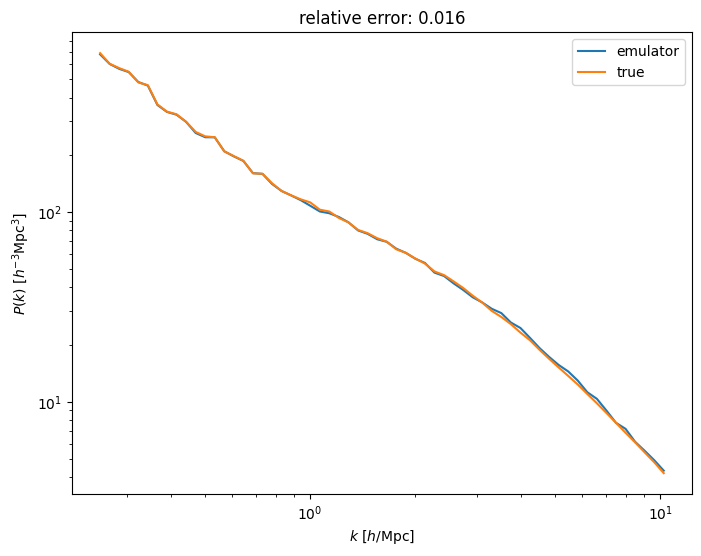

In [12]:
# plot
plt.figure(figsize=(8, 6))
plt.plot(k, Pk[0], label="emulator")
plt.plot(k, Pk_true_interp, label="true")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$P(k)$ [$h^{-3}$Mpc$^3$]")
plt.legend()
plt.title("relative error: %.3f" % rel_err)
plt.show()